In [ ]:
"""run a correlation analysis on each produce item to determine other similar items
stores the top 3 correlated produce items in an output array. 
Just does a correlation using pearson coefficient"""

In [90]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost.sklearn import XGBRegressor  
import pickle
from sklearn.model_selection import RandomizedSearchCV
sns.set_style("darkgrid")
import time
import math
import matplotlib.cm as cm

In [81]:
def generate_predict_start_dates(start_date, end_date, train_length, test_length, window_step):
    # generates a list of dates to start predicting from given a master start date/end date, 
    # as well as a training set length, test length, and step between each train+test pair.
    train_time = pd.to_timedelta(pd.np.ceil(train_length), unit="D")
    test_time = pd.to_timedelta(pd.np.ceil(test_length), unit="D")
    window_time = pd.to_timedelta(pd.np.ceil(window_step), unit='D')
    
    output_dates = [pd.to_datetime(start_date) + train_time]
    most_recent_date = pd.to_datetime(start_date) + train_time
    while most_recent_date + test_time <= pd.to_datetime(end_date):
        output_dates.append(most_recent_date + window_time)
        most_recent_date = most_recent_date + window_time
    return(output_dates)

In [82]:
def read_trimmed_data(city, veggie, data_dir):
    # reads in cleaned .csv data for one city and veggie, returns
    output_data = pd.read_csv(data_dir+veggie+'_'+city+'_TRIM.csv')
    output_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
    output_data['Date'] = pd.to_datetime(output_data['Date'])
    output_data = output_data.sort_values(by='Date')
    output_data = output_data.reset_index(drop=True)
    #output_data = normalize_price(output_data)
    return output_data

In [83]:
def normalize_price(input_data): 
    # normalize the price of the produce using the median/std (I never actually used this but I would want to change to MAD)
    input_data['Average Price'] = (input_data['Average Price'] - input_data['Average Price'].median())/input_data['Average Price'].std()
    return input_data

In [84]:
def nearest_date(dates, targdate):
    # finds nearest date to targdate in list of dates
    for i in dates:
        i = i.to_pydatetime()
    nearest = min(dates, key=lambda x: abs(x - targdate))
    timedelta = abs(nearest - targdate)
    return nearest, timedelta

In [85]:
def get_train_test_cluster(veggie_data, start_date, train_days, predict_days):
    # train test splitting specifically for this analysis
    all_dates = pd.to_datetime(veggie_data['Date'])
    train_time = pd.to_timedelta(pd.np.ceil(train_days), unit="D")
    test_time = pd.to_timedelta(pd.np.ceil(predict_days), unit="D")
    start_date_train = start_date - train_time
    nearest_date_train, deltatrain = nearest_date(all_dates, start_date_train)
    end_date_test = start_date + test_time
    nearest_date_test, deltatest = nearest_date(all_dates, end_date_test)
    training_set = veggie_data[(veggie_data['Date'] >= nearest_date_train) & (veggie_data['Date'] <= nearest_date_test)]
    return training_set

In [86]:
def build_set_clustering(veggie_data, start_dates, train_days, predict_days, vname):
    # builds a set of train/test splits for this analysis
    predicting_set = []
    for i in start_dates:
        one_month = get_train_test_cluster(veggie_data, i, train_days, predict_days)
        predicting_set.append(one_month['Average Price'].mean())
    # replace all nans with 0s
    predicting_set = [0.0 if math.isnan(x) else x for x in predicting_set]
    predicting_set = pd.Series(predicting_set).rename(vname+'_norm')
    return predicting_set

In [87]:
cities = ['NEW+YORK','LOS+ANGELES']
veggienames = ['APPLES','APRICOTS','ASPARAGUS','AVOCADOS','BANANAS','BEANS','BEETS','BLACKBERRIES','BLUEBERRIES','BROCCOLI','BRUSSELS+SPROUTS','CABBAGE','CANTALOUPS','CARROTS','CAULIFLOWER','CELERY','CHERRIES','CLEMENTINES', 'CUCUMBERS','ENDIVE','GARLIC','GINGER+ROOT','GRAPEFRUIT','GRAPES','HONEYDEWS','KIWIFRUIT','LEMONS','LETTUCE%2C+ICEBERG','LETTUCE%2C+ROMAINE','LETTUCE%2C+RED+LEAF','LETTUCE%2C+GREEN+LEAF', 'LIMES','MANGOES','NECTARINES','OKRA','ORANGES','PEACHES','PEARS','PEAS+GREEN','PEPPERS%2C+BELL+TYPE','PINEAPPLES','PLUMS','POTATOES','RADISHES','RASPBERRIES','RHUBARB','SPINACH','SQUASH','STRAWBERRIES']
#veggienames = ['APPLES', 'CARROTS']
datadir = './trimmed_data_and_plots/'

train_start_date = '20070601'
train_end_date = '20180531'
# three year train, 3 month test
train_length = 30
predict_length = 30
# increment window of train/test before generating new set
increment_test = 30

window_size = 15

In [88]:
# this takes a long time to run so try and do as little as possible - do subsequent operations in a new cell
# generate a list of dates 1 month apart - use them as the central dates
central_dates = generate_predict_start_dates(train_start_date, train_end_date, train_length, predict_length,increment_test)

output_info = pd.Series(central_dates).rename('Dates')

for v in veggienames:
    produce_data = read_trimmed_data(cities[1], v, datadir)
    produce_data = normalize_price(produce_data)

    cluster_data = build_set_clustering(produce_data, central_dates, window_size, window_size, v)

    output_info = pd.concat([output_info, cluster_data], axis=1)
    
output_info = output_info.set_index('Dates')


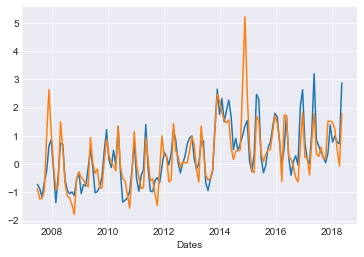

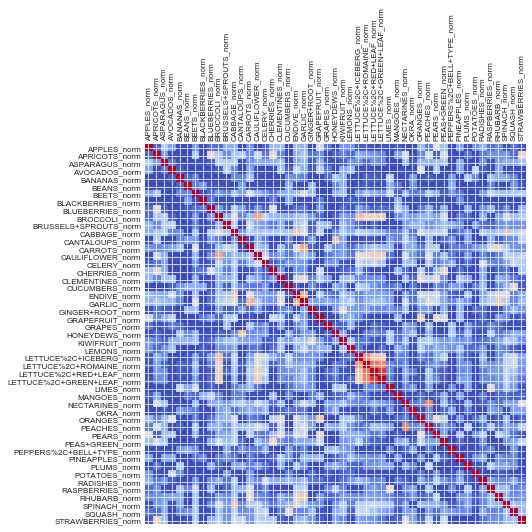

In [89]:
# now leverage ari's code - https://silburt.github.io/blog/stock_correlation.html
# save the correlation matrix
output_info['PEACHES_norm'].plot()
output_info['NECTARINES_norm'].plot()
#find correlation matrix, i.e. the "distances" between each stock
corr = output_info.corr()
size = 7
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(corr,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical', fontsize=8)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8)

plt.savefig('la_correlation_matrix.pdf', format='pdf', bbox_inches='tight')

indices = pd.Series(['top','second','third'])

for v in veggienames:
    correlations = corr[v+'_norm'].sort_values(ascending=False)
    best_matches = pd.Series(correlations[1:4].index).rename(v+'_norm')
    veggies = best_matches.str.strip('_norm')
    indices = pd.concat([indices, veggies], axis=1)

indices.to_csv('LOS+ANGELES_correlations.csv')
    

